In [31]:
import pandas as pd

market_df = pd.read_excel("/Users/pranavlakhotia/Downloads/Quant_Research_Project_TB/market_df.xlsx")

market_df

,time,banknifty,nifty,tte
0,2021-01-01 09:15:00,0.286058,0.199729,27
1,2021-01-01 09:16:00,0.285381,0.200433,27
2,2021-01-01 09:17:00,0.284233,0.200004,27
3,2021-01-01 09:18:00,0.286104,0.199860,27
4,2021-01-01 09:19:00,0.285539,0.198951,27
...,...,...,...,...
180851,2022-06-30 15:26:00,0.240701,0.214758,28
180852,2022-06-30 15:27:00,0.240875,0.216558,28
180853,2022-06-30 15:28:00,0.242115,0.216794,28
180854,2022-06-30 15:29:00,0.243426,0.216455,28


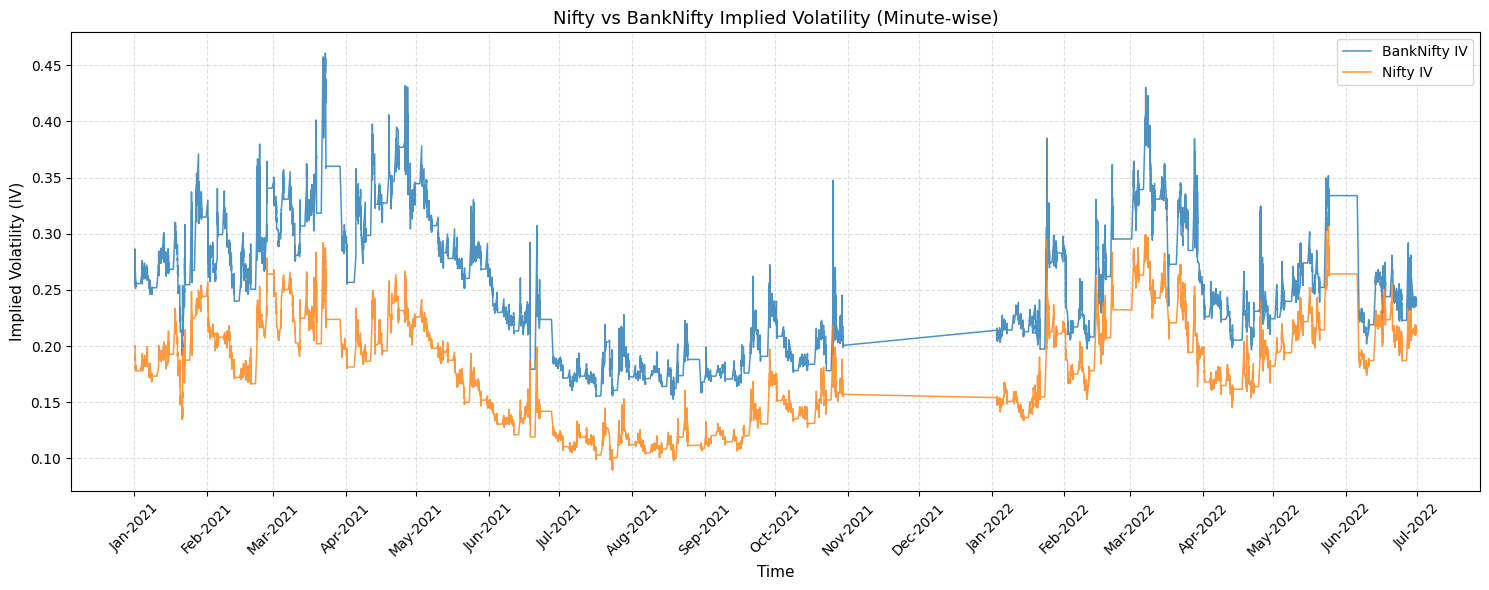

In [32]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(15,6))
plt.plot(market_df['time'], market_df['banknifty'], label='BankNifty IV', linewidth=1.1, alpha=0.8)
plt.plot(market_df['time'], market_df['nifty'], label='Nifty IV', linewidth=1.1, alpha=0.8)

plt.title('Nifty vs BankNifty Implied Volatility (Minute-wise)', fontsize=13)
plt.xlabel('Time', fontsize=11)
plt.ylabel('Implied Volatility (IV)', fontsize=11)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)

# Optional: better date formatting
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [33]:
abnormal_market_df = market_df.copy()

In [34]:
market_df['time'] = pd.to_datetime(market_df['time'])
print("Rows:", len(market_df))
print("Nulls:", market_df[['banknifty','nifty']].isna().sum())
display(market_df[['banknifty','nifty']].describe())

Rows: 180856
Nulls: banknifty    0
nifty        0
dtype: int64


,banknifty,nifty
count,180856.000000,180856.000000
mean,0.252428,0.180532
std,0.058503,0.046373
min,0.152732,0.089355
25%,0.208084,0.141933
50%,0.246825,0.181463
75%,0.295293,0.217764
max,0.460619,0.306953


In [35]:
import numpy as np

# Function to compute slope for every 3-point rolling segment
def rolling_slope_3pts(arr):
    """
    Computes slope of each 3-point rolling segment
    """
    n = len(arr)
    slopes = np.full(n, np.nan)
    for i in range(n - 2):
        x = np.array([0,1,2])
        y = arr[i:i+3]
        # Exact slope using np.polyfit degree=1
        a, _ = np.polyfit(x, y, 1)
        slopes[i] = a  # assign slope to the first point of the 3-point set
    return slopes

In [36]:
market_df['slope3_bnk'] = rolling_slope_3pts(market_df['banknifty'].values)
market_df['slope3_nifty'] = rolling_slope_3pts(market_df['nifty'].values)

In [37]:
def detect_exact_slope_segments(slopes, window_sets=10, set_size=3):
    """
    slopes: array of rolling slopes (3-point sets)
    window_sets: number of consecutive sets to check (10)
    set_size: size of each set (3 points)
    Returns: array of same length with -1 for invalid points, 0 otherwise
    """
    n = len(slopes)
    invalid_flag = np.zeros(n)
    
    for i in range(n - set_size - window_sets + 2):  # slide through all possible positions
        # Extract 5 consecutive slopes
        consecutive_slopes = slopes[i:i+window_sets]
        # Check if all slopes are exactly equal and not NaN
        if np.all(~np.isnan(consecutive_slopes)) and np.all(consecutive_slopes == consecutive_slopes[0]):
            # Calculate indices of points covered by these 5 sets
            start_idx = i
            end_idx = i + set_size + window_sets - 1  # inclusive
            invalid_flag[start_idx:end_idx+1] = -1
    return invalid_flag

In [38]:
market_df['invalid_bnk'] = detect_exact_slope_segments(market_df['slope3_bnk'].values)
market_df['invalid_nifty'] = detect_exact_slope_segments(market_df['slope3_nifty'].values)

print("Invalid points (BankNifty):", (market_df['invalid_bnk'] == -1).sum())
print("Invalid points (Nifty):", (market_df['invalid_nifty'] == -1).sum())

Invalid points (BankNifty): 67314
Invalid points (Nifty): 67314


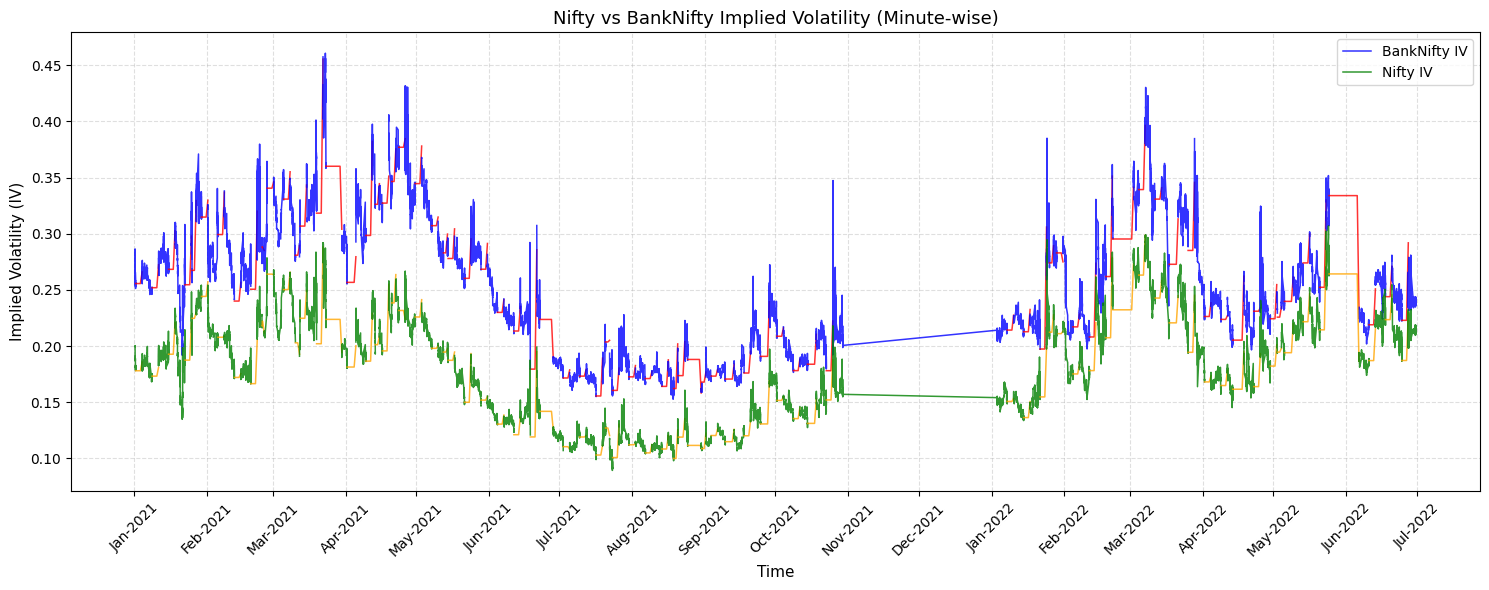

In [39]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

plt.figure(figsize=(15,6))

# Function to plot a line with segments in different colors based on a flag
def plot_with_invalid(x, y, invalid_flag, normal_color='blue', invalid_color='red', label=''):
    """
    x: time axis
    y: data values
    invalid_flag: array of same length as y; -1 = invalid, 0 = normal
    """
    invalid_flag = np.array(invalid_flag)
    y = np.array(y)
    x = np.array(x)
    
    # Find contiguous segments where invalid_flag is same
    start = 0
    while start < len(y):
        # Find end of this segment
        end = start
        while end+1 < len(y) and invalid_flag[end+1] == invalid_flag[start]:
            end += 1
        # Plot segment
        color = invalid_color if invalid_flag[start] == -1 else normal_color
        plt.plot(x[start:end+1], y[start:end+1], color=color, linewidth=1.1, alpha=0.8, label=label if start==0 else "")
        start = end + 1

# Plot BankNifty
plot_with_invalid(market_df['time'], market_df['banknifty'], market_df['invalid_bnk'], normal_color='blue', invalid_color='red', label='BankNifty IV')

# Plot Nifty
plot_with_invalid(market_df['time'], market_df['nifty'], market_df['invalid_nifty'], normal_color='green', invalid_color='orange', label='Nifty IV')

plt.title('Nifty vs BankNifty Implied Volatility (Minute-wise)', fontsize=13)
plt.xlabel('Time', fontsize=11)
plt.ylabel('Implied Volatility (IV)', fontsize=11)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)

# Optional: better date formatting
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

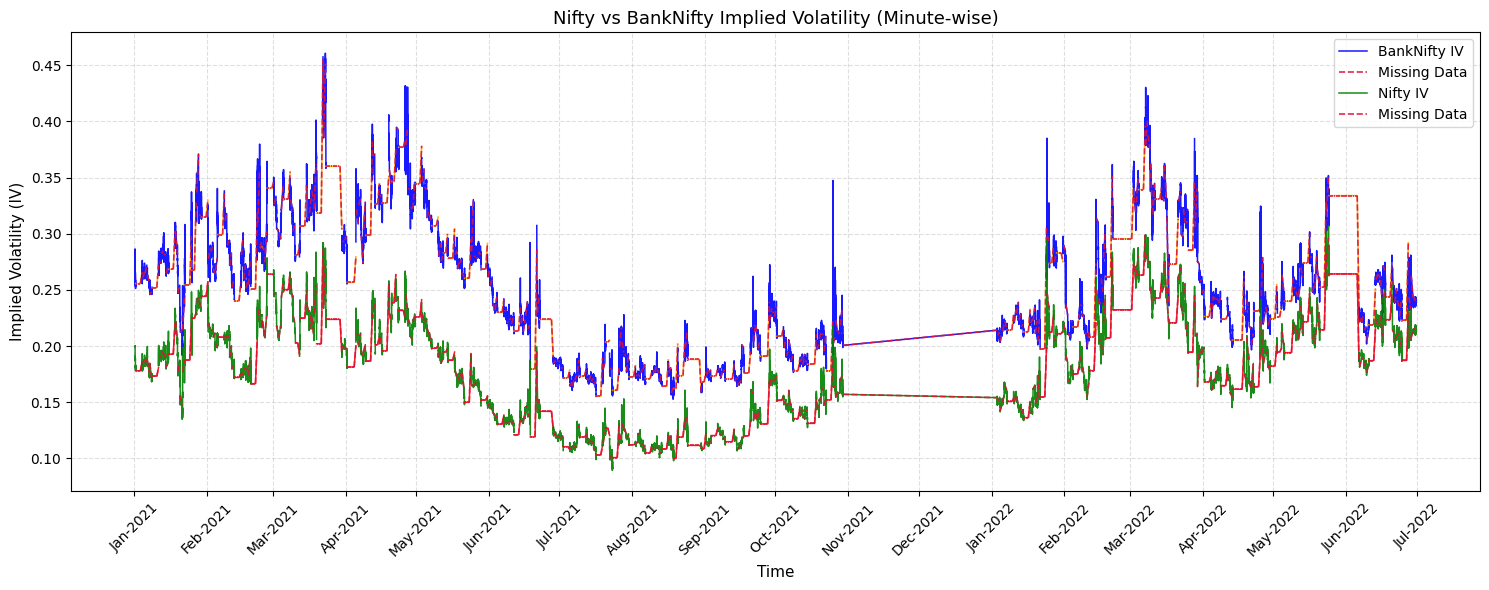

In [41]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd

plt.figure(figsize=(15,6))

def plot_with_invalid_and_missing(x, y, invalid_flag, normal_color='blue', invalid_color='red', missing_color='crimson', label=''):
    """
    Plots data with:
    - normal segments (normal_color)
    - invalid segments (-1 flag → invalid_color)
    - missing data gaps (detected via large time jumps → missing_color)
    """
    x = pd.to_datetime(np.array(x))
    y = np.array(y)
    invalid_flag = np.array(invalid_flag)

    # Median gap for regular sampling
    time_diffs = np.diff(x)
    median_gap = np.median(time_diffs)
    gap_indices = np.where(time_diffs > 3 * median_gap)[0]  # consider 3× median as gap threshold

    # Plot normal/invalid segments
    start = 0
    while start < len(y):
        end = start
        while end + 1 < len(y) and invalid_flag[end + 1] == invalid_flag[start]:
            end += 1
        color = invalid_color if invalid_flag[start] == -1 else normal_color
        plt.plot(x[start:end+1], y[start:end+1], color=color, linewidth=1.1, alpha=0.9, label=label if start == 0 else "")
        start = end + 1

    # Plot missing data connectors in missing_color
    for idx in gap_indices:
        plt.plot([x[idx], x[idx+1]], [y[idx], y[idx+1]], color=missing_color, linewidth=1.2, alpha=0.9, linestyle='--', label='Missing Data' if idx == gap_indices[0] else "")

# Plot BankNifty
plot_with_invalid_and_missing(
    market_df['time'],
    market_df['banknifty'],
    market_df['invalid_bnk'],
    normal_color='blue',
    invalid_color='orange',
    missing_color='crimson',
    label='BankNifty IV'
)

# Plot Nifty
plot_with_invalid_and_missing(
    market_df['time'],
    market_df['nifty'],
    market_df['invalid_nifty'],
    normal_color='green',
    invalid_color='red',
    missing_color='crimson',
    label='Nifty IV'
)

plt.title('Nifty vs BankNifty Implied Volatility (Minute-wise)', fontsize=13)
plt.xlabel('Time', fontsize=11)
plt.ylabel('Implied Volatility (IV)', fontsize=11)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)

# Better x-axis formatting
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

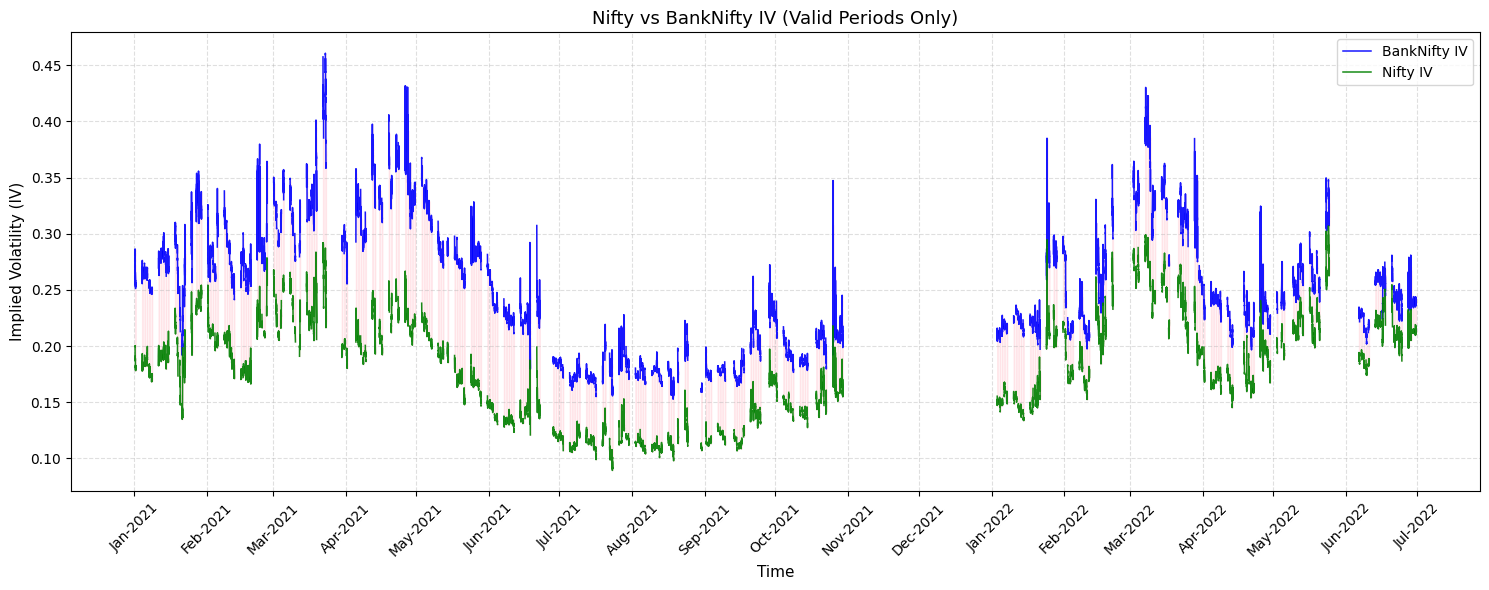

In [42]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd

plt.figure(figsize=(15,6))

def plot_valid_shaded(x, y1, y2, invalid_flag1, invalid_flag2, normal_color1='blue', normal_color2='green', shade_color='#ffb6c1', label1='', label2=''):
    """
    Plot valid data of two series with shaded region between them.
    Invalid (-1) or missing data segments are skipped (blank).
    """
    x = pd.to_datetime(np.array(x))
    y1 = np.array(y1)
    y2 = np.array(y2)
    invalid_flag1 = np.array(invalid_flag1)
    invalid_flag2 = np.array(invalid_flag2)

    # Detect missing data based on large time gaps
    time_diffs = np.diff(x)
    median_gap = np.median(time_diffs)
    gap_indices = np.where(time_diffs > 3 * median_gap)[0]

    # Create valid mask (both valid and continuous)
    valid_mask = (invalid_flag1 != -1) & (invalid_flag2 != -1)
    
    # Mark missing gaps as invalid
    missing_mask = np.zeros_like(valid_mask)
    for idx in gap_indices:
        missing_mask[idx:idx+2] = 1
    valid_mask[missing_mask == 1] = False

    # Find continuous valid segments
    start = 0
    while start < len(x):
        # Skip invalids
        while start < len(x) and not valid_mask[start]:
            start += 1
        if start >= len(x):
            break

        # Find end of this continuous valid segment
        end = start
        while end + 1 < len(x) and valid_mask[end + 1]:
            end += 1

        # Plot valid segment and shade
        plt.plot(x[start:end+1], y1[start:end+1], color=normal_color1, linewidth=1.1, alpha=0.9, label=label1 if start == 0 else "")
        plt.plot(x[start:end+1], y2[start:end+1], color=normal_color2, linewidth=1.1, alpha=0.9, label=label2 if start == 0 else "")
        plt.fill_between(x[start:end+1], y1[start:end+1], y2[start:end+1], color=shade_color, alpha=0.25)

        start = end + 1

# Apply function
plot_valid_shaded(
    market_df['time'],
    market_df['banknifty'],
    market_df['nifty'],
    market_df['invalid_bnk'],
    market_df['invalid_nifty'],
    normal_color1='blue',
    normal_color2='green',
    shade_color='#ffb6c1',
    label1='BankNifty IV',
    label2='Nifty IV'
)

plt.title('Nifty vs BankNifty IV (Valid Periods Only)', fontsize=13)
plt.xlabel('Time', fontsize=11)
plt.ylabel('Implied Volatility (IV)', fontsize=11)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)

# Format x-axis
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [43]:
# Create a boolean mask for valid data points
valid_mask = (
    (market_df['invalid_bnk'] != -1) &
    (market_df['invalid_nifty'] != -1) &
    (~market_df['banknifty'].isna()) &
    (~market_df['nifty'].isna())
)

# Filter and keep only the required columns
valid_market_df = market_df.loc[valid_mask, ['time', 'banknifty', 'nifty', 'tte']].reset_index(drop=True)

print("Original data points:", len(market_df))
print("Valid data points:", len(valid_market_df))
display(valid_market_df)

Original data points: 180856
Valid data points: 113541


,time,banknifty,nifty,tte
0,2021-01-01 09:15:00,0.286058,0.199729,27
1,2021-01-01 09:16:00,0.285381,0.200433,27
2,2021-01-01 09:17:00,0.284233,0.200004,27
3,2021-01-01 09:18:00,0.286104,0.199860,27
4,2021-01-01 09:19:00,0.285539,0.198951,27
...,...,...,...,...
113536,2022-06-30 15:26:00,0.240701,0.214758,28
113537,2022-06-30 15:27:00,0.240875,0.216558,28
113538,2022-06-30 15:28:00,0.242115,0.216794,28
113539,2022-06-30 15:29:00,0.243426,0.216455,28


In [44]:
valid_market_df.to_excel("valid_market_df.xlsx", index=False)